<a href="https://colab.research.google.com/github/PavaniPerisetla/DogVsCat/blob/main/DogVsCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Path to dataset files: /kaggle/input/microsoft-catsvsdogs-dataset


#import requred libraries

In [ ]:
import os, cv2, numpy as np, random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#Access Dataset

In [ ]:
DATASET_PATH = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
CAT_DIR = os.path.join(DATASET_PATH, "Cat")
DOG_DIR = os.path.join(DATASET_PATH, "Dog")

IMG_SIZE = 128   # resize size
MAX_IMAGES = 5000   # limit for speed (adjust if you want more)

def load_images(img_dir, label, max_count):
    data, labels = [], []
    files = os.listdir(img_dir)[:max_count]
    for fname in tqdm(files, desc=f"Loading {label}"):
        fpath = os.path.join(img_dir, fname)
        try:
            img = cv2.imread(fpath, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except:
            continue
    return data, labels

cat_data, cat_labels = load_images(CAT_DIR, 0, MAX_IMAGES//2)
dog_data, dog_labels = load_images(DOG_DIR, 1, MAX_IMAGES//2)

X = np.array(cat_data + dog_data)
y = np.array(cat_labels + dog_labels)

print("Dataset:", X.shape, y.shape)


Loading 1: 100%|██████████| 2500/2500 [00:27<00:00, 90.23it/s]

Dataset: (5000, 128, 128, 3) (5000,)


#Feature extraction with HOG

In [ ]:
from skimage.feature import hog
from skimage import color

def extract_hog_features(images):
    feats = []
    for img in tqdm(images, desc="Extracting HOG"):
        gray = color.rgb2gray(img)
        feat = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True,
        )
        feats.append(feat)
    return np.array(feats)

X_feats = extract_hog_features(X)
print("Feature shape:", X_feats.shape)


Extracting HOG: 100%|██████████| 5000/5000 [00:34<00:00, 143.44it/s]


Feature shape: (5000, 8100)


#split train and test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_feats, y, test_size=0.2, random_state=42, stratify=y
)


#training

In [ ]:
svm = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(C=1.0, max_iter=5000, random_state=42)
)

print("Training SVM...")
svm.fit(X_train, y_train)

print("Validation Accuracy:", svm.score(X_val, y_val))


Training SVM...
Validation Accuracy: 0.646


#Prediction

In [ ]:
y_pred = svm.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Cat","Dog"]))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.65      0.62      0.64       500
         Dog       0.64      0.67      0.65       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000

Confusion Matrix:
[[310 190]
 [164 336]]


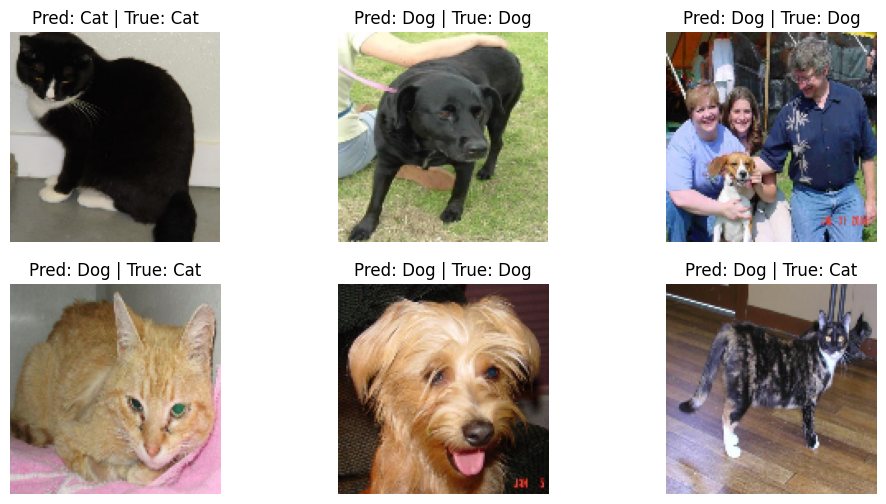

In [ ]:
def show_predictions(n=6):
    idxs = np.random.choice(len(y_val), n, replace=False)
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(idxs, 1):
        img = X_val[idx].reshape(-1)  # already HOG, can't reconstruct full image
        # Instead, show original resized input
        orig_idx = np.where((X_feats == X_val[idx]).all(axis=1))[0][0]
        orig_img = X[orig_idx]

        plt.subplot(2, (n+1)//2, i)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        pred = "Dog" if y_pred[idx] == 1 else "Cat"
        true = "Dog" if y_val[idx] == 1 else "Cat"
        plt.title(f"Pred: {pred} | True: {true}")
    plt.show()

show_predictions(6)
